In [0]:
# Use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132681 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse -o nonempty drive

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [0]:
#import library
import pandas as pd
import numpy as np
from glob import glob
import fnmatch
import cv2


from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
X1=np.load('X_new.npy')
Y1=np.load('Y_new.npy')

X=X1[0:40000]
Y=Y1[0:40000]

In [0]:
def describe_data(x,y):
    print('Total number: {}'.format(len(x)))
    print('Number of IDC(-): {}'.format(np.sum(y==0)))
    print('Number of IDC(+): {}'.format(np.sum(y==1)))
    print('Percentage of IDC(+) : {:.2f}%'.format(100*np.mean(y)))
describe_data(X, Y)

Total number: 40000
Number of IDC(-): 30556
Number of IDC(+): 9444
Percentage of IDC(+) : 23.61%


In [0]:
x_sub = np.array(X)
x_sub=x_sub/255.0
x_sub_shape = x_sub.shape[1] * x_sub.shape[2] * x_sub.shape[3]
x_flat = x_sub.reshape(x_sub.shape[0], x_sub_shape)

In [0]:
r = pd.value_counts(Y)
print(r)
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(ratio='auto')
x_flat_resample,y_sub_resample=rus.fit_sample(x_flat,Y)
len(x_flat_resample)
r = pd.value_counts(y_sub_resample)
print(r)

0    30556
1     9444
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


1    9444
0    9444
dtype: int64


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_flat_resample, y_sub_resample, test_size=0.2, random_state = 2) # 0.2 test_size means 20%

In [0]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (15110, 7500)
Testing Data Shape: (3778, 7500)


In [0]:
for i in range(len(X_train)):
    height, width, channels = 50,50,3
    X_train_reshape = X_train.reshape(len(X_train),height,width,channels)

for i in range(len(X_test)):
    height, width, channels = 50,50,3
    X_test_reshape = X_test.reshape(len(X_test),height,width,channels)

In [0]:
from keras.utils.np_utils import to_categorical
y_train_c = to_categorical(y_train, num_classes = 2)
y_test_c = to_categorical(y_test, num_classes = 2)

datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) 

In [0]:
print(X_train_reshape.shape)
print(y_train_c.shape)
print(X_test_reshape.shape)
print(y_test_c.shape)

(15110, 50, 50, 3)
(15110, 2)
(3778, 50, 50, 3)
(3778, 2)


In [0]:
def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

In [0]:
def convolution_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X


In [0]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
 
    X_input = Input(input_shape)
 
    X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (7, 7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2,2))(X)
 
    X = convolution_block(X, f = 3, filters = [64,64,256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [64,64,256], stage=2, block='b')
    X = identity_block(X, 3, [64,64,256], stage=2, block='c')
 
    X = convolution_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')
 
    X = convolution_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
    X = convolution_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
 
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
 
    return model


In [0]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [0]:
model = ResNet50(input_shape = (50,50,3), classes = 2)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train_reshape,y_train_c, batch_size=32),validation_data=(X_test_reshape,y_test_c),
                        steps_per_epoch=len(X_train) / 32, epochs=150,callbacks = [MetricsCheckpoint('logs')],verbose=1)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/150
473/472 [==============================] - 64s 135ms/step - loss: 0.7459 - acc: 0.7633 - val_loss: 0.5880 - val_acc: 0.7914
Epoch 2/150
473/472 [==============================] - 48s 102ms/step - loss: 0.7039 - acc: 0.7335 - val_loss: 0.6661 - val_acc: 0.7409
Epoch 3/150
473/472 [==============================] - 48s 102ms/step - loss: 0.5978 - acc: 0.7660 - val_loss: 0.6190 - val_acc: 0.7906
Epoch 4/150
473/472 [==============================] - 48s 101ms/step - loss: 0.6796 - acc: 0.7554 - val_loss: 0.6392 - val_acc: 0.7684
Epoch 5/150
473/472 [==============================] - 48s 102ms/step - loss: 0.5629 - acc: 0.7838 - val_loss: 0.5023 - val_acc: 0.7882
Epoch 6/150
473/472 [==============================] - 48s 102ms/step - loss: 0.5902 - acc: 0.7681 - val_loss: 0.6392 - val_acc: 0.7520
Epoch 7/150
473/472 [==============================] - 48s 102ms/step - los

In [0]:
def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_lc(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    

In [0]:
score = model.evaluate(X_test_reshape,y_test_c)
print(score)

3778/3778 [==============================] - 2s 487us/step
[0.28647664900871106, 0.8742721016410799]


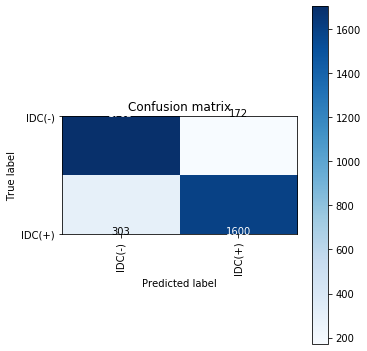

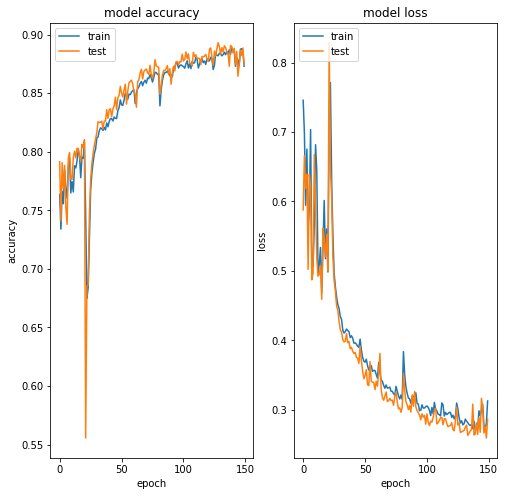

In [0]:
import itertools
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
y_pred = model.predict(X_test_reshape)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test_c,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_cm(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()
plot_lc(history)
plt.show()

In [0]:
print(confusion_matrix(Y_true, Y_pred_classes))

from sklearn import metrics
print(metrics.classification_report(Y_true, Y_pred_classes))


[[1703  172]
 [ 303 1600]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1875
           1       0.90      0.84      0.87      1903

    accuracy                           0.87      3778
   macro avg       0.88      0.87      0.87      3778
weighted avg       0.88      0.87      0.87      3778



In [0]:
cm= confusion_matrix(Y_true, Y_pred_classes)
sensitivity= cm[1,1]/(cm[1,1]+cm[1,0])
print('Sensitivity : ', sensitivity )
secificity= cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ',secificity)

Sensitivity :  0.8407777193904361
Specificity :  0.9082666666666667


In [0]:
from sklearn.metrics import auc,roc_curve

#  ROC curve
fpr, tpr, thresholds = roc_curve(Y_true, y_pred[:,1], pos_label=1)

#  AUC
pred_score = auc(fpr, tpr)
print(f'Area Under Curve is {pred_score}')

Area Under Curve is 0.952342196531792


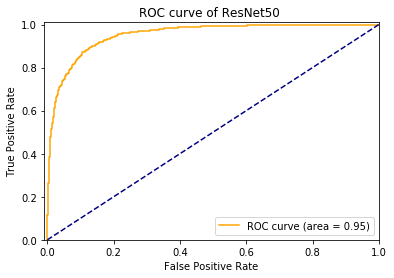

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of ResNet50 ')
plt.legend(loc="lower right")

In [0]:
pred = model.predict(X_test_reshape)
pred_x = []
for i in range(len(pred)):
  if pred[i,1]>0.5:
    pred_x.append(1)
  else:
    pred_x.append(0)

a = []
b = 0
for i in range(len(pred)):
  if pred_x[i] == y_test_c[i,1]:
    a.append('yes')
    b=b+1
  else:
    a.append('no')
type(a)
df = pd.DataFrame(a, columns=['ResNet'])
print(df)
df.to_csv('resnet_yes-no.csv', index=False, header=True)

     ResNet
0       yes
1       yes
2       yes
3        no
4       yes
...     ...
3773    yes
3774    yes
3775     no
3776     no
3777     no

[3778 rows x 1 columns]
